In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper
from psiam_tied_dv_map_utils import cum_A_t_fn, cum_E_t_fn, down_RTs_fit_TRUNC_fn, up_RTs_fit_TRUNC_fn
from psiam_tied_dv_map_utils import psiam_tied_data_gen_wrapper_V4
from psiam_tied_no_dv_map_utils import rho_E_minus_small_t_NORM_fn

In [30]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

vp_sample = vp.sample(int(1e6))[0]

V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04

t_A_aff = np.mean(vp_sample[:,2]) - t_motor


with open('right_trunc_with_aborts.pkl', 'rb') as f:
    vp_trunc = pickle.load(f).vp

vp_samples_trunc = vp_trunc.sample(int(1e6))[0]


rate_lambda = np.mean(vp_samples_trunc[:,0])

T0 = 0.5*np.mean(vp_samples_trunc[:,1]) 

theta_E = np.mean(vp_samples_trunc[:,2])
t_E_aff = np.mean(vp_samples_trunc[:,3])
Z_E = np.mean(vp_samples_trunc[:,4])

In [31]:
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In iter_num: 0, ABL: 40, ILD: -8.0, t_stim: 0.996819737758429
In iter_num: 0, ABL: 60, ILD: 16.0, t_stim: 0.996819737758429
In iter_num: 0, ABL: 20, ILD: 4.0, t_stim: 0.996819737758429
In iter_num: 0, ABL: 20, ILD: 1.0, t_stim: 0.996819737758429
In iter_num: 0, ABL: 60, ILD: 1.0, t_stim: 0.996819737758429
In iter_num: 0, ABL: 40, ILD: 4.0, t_stim: 0.996819737758429
In iter_num: 0, ABL: 60, ILD: -1.0, t_stim: 0.996819737758429
In iter_num: 0, ABL: 40, ILD: -4.0, t_stim: 0.996819737758429


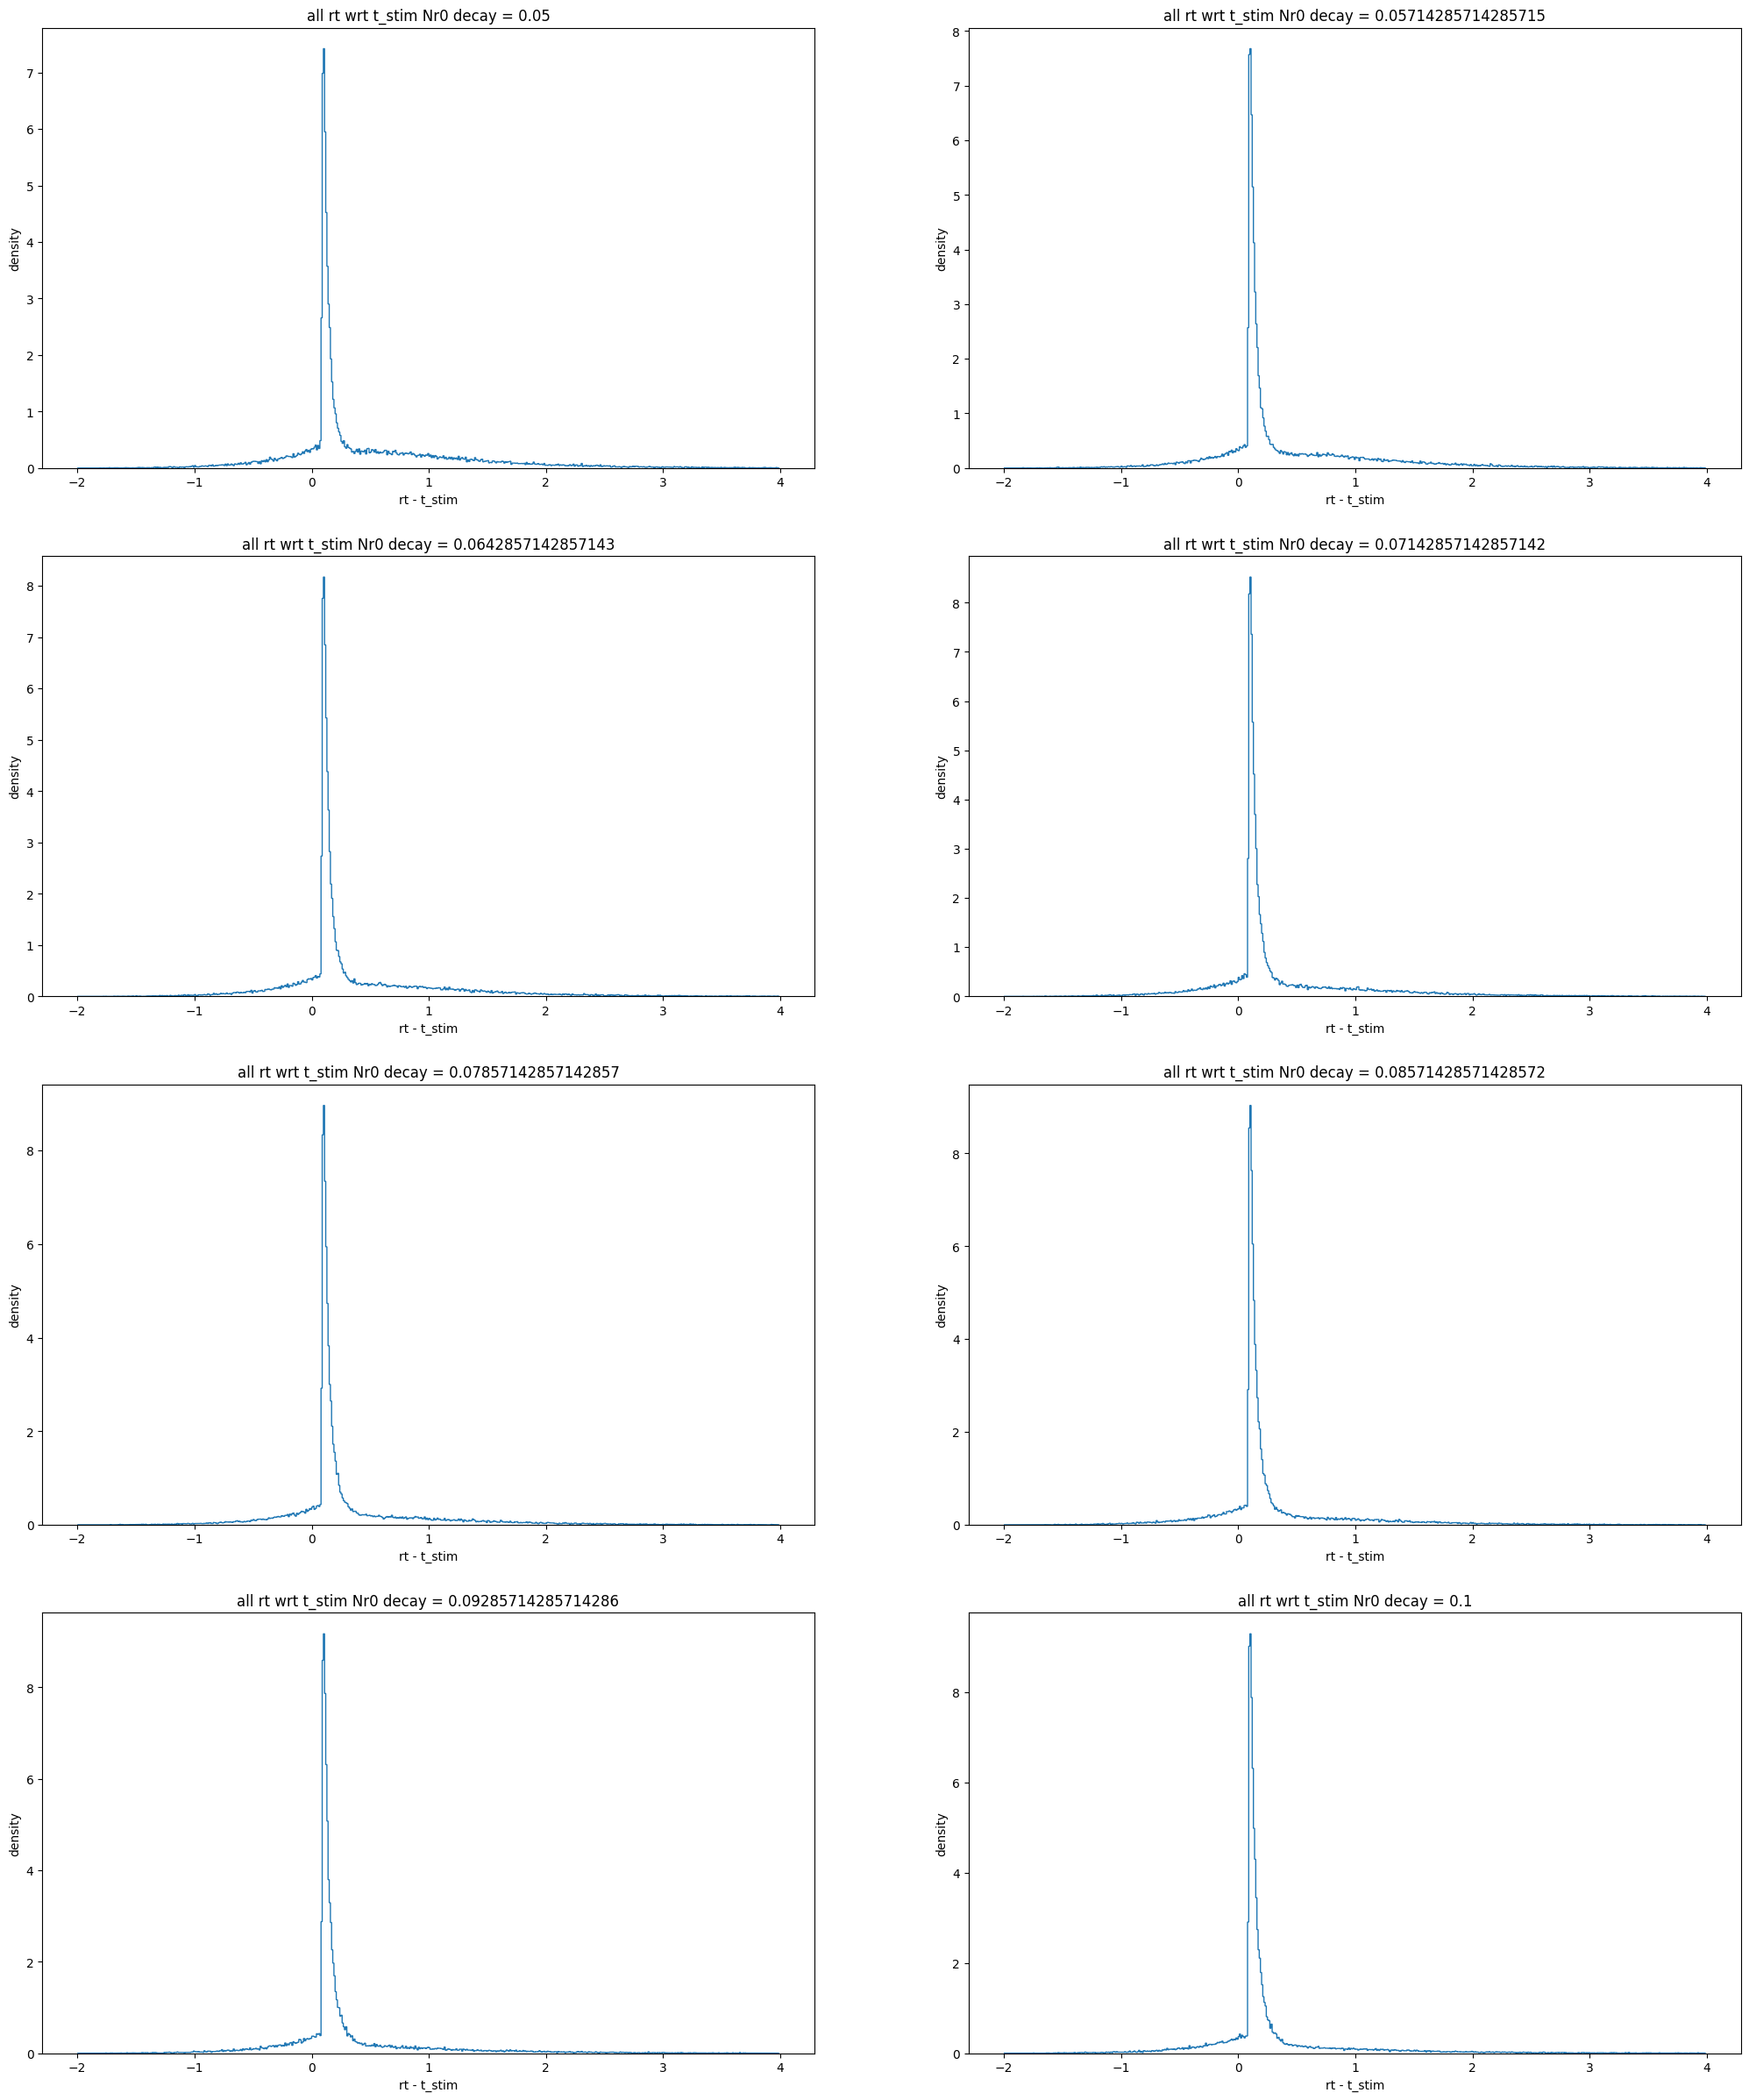

In [34]:
# decay_values = [0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2]
decay_values = np.linspace(0.05, 0.1, 8)

f = 1
N_sim = int(50e3)
N_print = int(1e6 + 1)
dt = 1e-3; dB = np.sqrt(dt);
t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)
bins = np.arange(-2,4, 0.01)

plt.figure(figsize=(25,30))
for decay in decay_values:
    T_0_tau = decay
    L = 1
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V4)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T0, T_0_tau, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 
    rt = [res['rt'] - res['t_stim'] for res in sim_results if not ( res['rt'] < res['t_stim'] and res['rt'] < 0.3 )]
    plt.subplot(4,2,f)
    plt.hist(rt, bins=bins, density=True, histtype='step');
    plt.xlabel('rt - t_stim')
    plt.ylabel('density')
    plt.title(f'all rt wrt t_stim Nr0 decay = {T_0_tau}')
    f += 1


# rough 

In [3]:
T0 = 0.5 * (1e-3)

In [ ]:
Nr0 = 1/T0

t_pts = np.arange(0, 1, 0.01)


tau = 0.2
Nrt = Nr0 * np.exp(-t_pts/tau)
Tt = 1/Nrt
plt.plot(t_pts, Tt)
plt.show()
plt.plot(t_pts, Nrt)